In [ ]:
## This demo is a learning note from this github https://github.com/bentrevett/pytorch-sentiment-analysis/tree/main.

### Learn how to retrain a word embedding using existing word embedding.

Torchtext0.15.1 and Torch2.0.0 are compatible with each other for this demo!!

In [ ]:
!pip install torchtext==0.15.1 --no-cache-dir
!pip install torch==2.0.0 --no-cache-dir
!pip install datasets

!pip show torchtext
!pip show torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 212.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 303.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 149.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 302.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 194.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 334.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 211.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 199.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 158.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 180.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 193.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# check GPU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Mar 17 03:37:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             42W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import io
import os
import re
import shutil
import string
import torch
import torchtext
import numpy as np
# check whether gpu is available
torch.cuda.is_available()

True

In [ ]:
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [ ]:

from datasets import load_dataset

# load imdb dataset
train, test = load_dataset("imdb",split=['train','test'])

In [ ]:
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer("basic_english")

def example_tokneizer(example, tokenizer, max_length):
  example['tokens'] = tokenizer(example['text'])[:max_length]
  return example

max_length = 256
train = train.map(example_tokneizer,fn_kwargs={'tokenizer':tokenizer, 'max_length':max_length})
test = test.map(example_tokneizer, fn_kwargs={'tokenizer':tokenizer, 'max_length':max_length})

test_size=0.2
tra = train.train_test_split(test_size=test_size,shuffle=True,seed=seed)
train_dataset = tra['train']
valid_dataset = tra['test']

# build vocab
from torchtext.vocab import build_vocab_from_iterator

min_freq=5
vocab = build_vocab_from_iterator(
    train_dataset['tokens'],
    min_freq=min_freq,
    specials=["<unk>","<pad>"])

vocab.set_default_index(vocab["<unk>"])

pad_sequence = vocab["<pad>"]


def numerize_tokens(example,vocab):
  example['ids'] = vocab.lookup_indices(example['tokens'])
  return example

train_dataset = train_dataset.map(numerize_tokens,fn_kwargs={'vocab':vocab})
valid_dataset = valid_dataset.map(numerize_tokens,fn_kwargs={'vocab':vocab})
test_dataset = test.map(numerize_tokens,fn_kwargs={'vocab':vocab})

# convert to tensor
train_dataset = train_dataset.with_format(type='torch',columns=['ids','label'])
valid_dataset = valid_dataset.with_format(type='torch',columns=['ids','label'])
test_dataset = test_dataset.with_format(type='torch',columns=['ids','label'])


# build collate function
def collate_batch(pad_index):

  def collate_fn(batch):
    ids = [item['ids'] for item in batch]
    labels = [item['label'] for item in batch]
    ids = torch.nn.utils.rnn.pad_sequence(ids, padding_value=pad_index,batch_first=True, )
    labels = torch.stack(labels)
    return {'ids':ids, 'labels':labels}

  return collate_fn

def data_loader(dataset, batch_size, pad_sequence,shuffle=False):
  collate_fn = collate_batch(pad_sequence)
  loader = torch.utils.data.DataLoader(dataset = dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)
  return loader

# initialize dataloader
batch_size = 512
train_loader = data_loader(train_dataset, batch_size, pad_sequence,shuffle=True)
valid_loader = data_loader(valid_dataset, batch_size, pad_sequence)
test_loader = data_loader(test_dataset, batch_size,  pad_sequence)


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
train_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

length of vocab: 22293


training...:   2%|▎         | 1/40 [00:00<00:03,  9.82it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  12%|█▎        | 5/40 [00:00<00:03, 11.18it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  18%|█▊        | 7/40 [00:00<00:02, 11.46it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  28%|██▊       | 11/40 [00:00<00:02, 11.69it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  32%|███▎      | 13/40 [00:01<00:02, 11.72it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  42%|████▎     | 17/40 [00:01<00:01, 11.76it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  48%|████▊     | 19/40 [00:01<00:01, 11.77it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  57%|█████▊    | 23/40 [00:01<00:01, 11.84it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  62%|██████▎   | 25/40 [00:02<00:01, 11.84it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  72%|███████▎  | 29/40 [00:02<00:00, 11.80it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  78%|███████▊  | 31/40 [00:02<00:00, 11.81it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  88%|████████▊ | 35/40 [00:02<00:00, 11.81it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  92%|█████████▎| 37/40 [00:03<00:00, 11.81it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...: 100%|██████████| 40/40 [00:03<00:00, 11.97it/s]


first embedded shape torch.Size([32, 256, 300])
embedded shape torch.Size([32, 1, 256, 300])
conved0 shape torch.Size([32, 100, 249])
conved1 shape torch.Size([32, 100, 241])
pooled0 shape torch.Size([32, 100])
pooled1 shape torch.Size([32, 100])
cat shape torch.Size([32, 200])
prediction shape torch.Size([32, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512

 20%|██        | 1/5 [00:03<00:15,  3.83s/it]

first embedded shape torch.Size([392, 256, 300])
embedded shape torch.Size([392, 1, 256, 300])
conved0 shape torch.Size([392, 100, 249])
conved1 shape torch.Size([392, 100, 241])
pooled0 shape torch.Size([392, 100])
pooled1 shape torch.Size([392, 100])
cat shape torch.Size([392, 200])
prediction shape torch.Size([392, 2])
epoch: 0
train_loss: 0.642, train_acc: 0.651
valid_loss: 0.472, valid_acc: 0.809



training...:   5%|▌         | 2/40 [00:00<00:03, 12.03it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  10%|█         | 4/40 [00:00<00:03, 11.94it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  15%|█▌        | 6/40 [00:00<00:02, 11.93it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  20%|██        | 8/40 [00:00<00:02, 11.94it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  25%|██▌       | 10/40 [00:00<00:02, 11.96it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  30%|███       | 12/40 [00:01<00:02, 11.95it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  35%|███▌      | 14/40 [00:01<00:02, 11.96it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  40%|████      | 16/40 [00:01<00:02, 11.95it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  45%|████▌     | 18/40 [00:01<00:01, 11.95it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  50%|█████     | 20/40 [00:01<00:01, 11.96it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  55%|█████▌    | 22/40 [00:01<00:01, 11.95it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  60%|██████    | 24/40 [00:02<00:01, 11.97it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  65%|██████▌   | 26/40 [00:02<00:01, 11.98it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  70%|███████   | 28/40 [00:02<00:01, 11.96it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  75%|███████▌  | 30/40 [00:02<00:00, 11.92it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  80%|████████  | 32/40 [00:02<00:00, 11.93it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  85%|████████▌ | 34/40 [00:02<00:00, 11.95it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  90%|█████████ | 36/40 [00:03<00:00, 11.98it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  95%|█████████▌| 38/40 [00:03<00:00, 11.98it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])


training...: 100%|██████████| 40/40 [00:03<00:00, 12.22it/s]


first embedded shape torch.Size([32, 256, 300])
embedded shape torch.Size([32, 1, 256, 300])
conved0 shape torch.Size([32, 100, 249])
conved1 shape torch.Size([32, 100, 241])
pooled0 shape torch.Size([32, 100])
pooled1 shape torch.Size([32, 100])
cat shape torch.Size([32, 200])
prediction shape torch.Size([32, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512

 40%|████      | 2/5 [00:07<00:11,  3.79s/it]

first embedded shape torch.Size([392, 256, 300])
embedded shape torch.Size([392, 1, 256, 300])
conved0 shape torch.Size([392, 100, 249])
conved1 shape torch.Size([392, 100, 241])
pooled0 shape torch.Size([392, 100])
pooled1 shape torch.Size([392, 100])
cat shape torch.Size([392, 200])
prediction shape torch.Size([392, 2])
epoch: 1
train_loss: 0.399, train_acc: 0.827
valid_loss: 0.352, valid_acc: 0.847



training...:   0%|          | 0/40 [00:00<?, ?it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:   5%|▌         | 2/40 [00:00<00:03, 12.09it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  10%|█         | 4/40 [00:00<00:03, 11.97it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  15%|█▌        | 6/40 [00:00<00:02, 11.99it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  20%|██        | 8/40 [00:00<00:02, 11.95it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  25%|██▌       | 10/40 [00:00<00:02, 11.92it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  30%|███       | 12/40 [00:01<00:02, 11.87it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  35%|███▌      | 14/40 [00:01<00:02, 11.86it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  40%|████      | 16/40 [00:01<00:02, 11.87it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  45%|████▌     | 18/40 [00:01<00:01, 11.85it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  50%|█████     | 20/40 [00:01<00:01, 11.80it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  55%|█████▌    | 22/40 [00:01<00:01, 11.82it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  60%|██████    | 24/40 [00:02<00:01, 11.83it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  65%|██████▌   | 26/40 [00:02<00:01, 11.88it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  70%|███████   | 28/40 [00:02<00:01, 11.47it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  75%|███████▌  | 30/40 [00:02<00:00, 11.20it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  80%|████████  | 32/40 [00:02<00:00, 11.37it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  85%|████████▌ | 34/40 [00:02<00:00, 11.50it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  90%|█████████ | 36/40 [00:03<00:00, 11.63it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  95%|█████████▌| 38/40 [00:03<00:00, 11.68it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])


training...: 100%|██████████| 40/40 [00:03<00:00, 11.98it/s]


first embedded shape torch.Size([32, 256, 300])
embedded shape torch.Size([32, 1, 256, 300])
conved0 shape torch.Size([32, 100, 249])
conved1 shape torch.Size([32, 100, 241])
pooled0 shape torch.Size([32, 100])
pooled1 shape torch.Size([32, 100])
cat shape torch.Size([32, 200])
prediction shape torch.Size([32, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512

 60%|██████    | 3/5 [00:11<00:07,  3.81s/it]

first embedded shape torch.Size([392, 256, 300])
embedded shape torch.Size([392, 1, 256, 300])
conved0 shape torch.Size([392, 100, 249])
conved1 shape torch.Size([392, 100, 241])
pooled0 shape torch.Size([392, 100])
pooled1 shape torch.Size([392, 100])
cat shape torch.Size([392, 200])
prediction shape torch.Size([392, 2])
epoch: 2
train_loss: 0.298, train_acc: 0.877
valid_loss: 0.301, valid_acc: 0.872



training...:   0%|          | 0/40 [00:00<?, ?it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:   5%|▌         | 2/40 [00:00<00:03, 12.04it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  10%|█         | 4/40 [00:00<00:03, 11.99it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  15%|█▌        | 6/40 [00:00<00:02, 11.99it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  20%|██        | 8/40 [00:00<00:02, 12.00it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  25%|██▌       | 10/40 [00:00<00:02, 11.93it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  30%|███       | 12/40 [00:01<00:02, 11.87it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  35%|███▌      | 14/40 [00:01<00:02, 11.90it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  40%|████      | 16/40 [00:01<00:02, 11.90it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  45%|████▌     | 18/40 [00:01<00:01, 11.86it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  50%|█████     | 20/40 [00:01<00:01, 11.83it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  55%|█████▌    | 22/40 [00:01<00:01, 11.85it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  60%|██████    | 24/40 [00:02<00:01, 11.86it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  65%|██████▌   | 26/40 [00:02<00:01, 11.88it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  70%|███████   | 28/40 [00:02<00:01, 11.90it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  75%|███████▌  | 30/40 [00:02<00:00, 11.94it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  80%|████████  | 32/40 [00:02<00:00, 11.91it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  85%|████████▌ | 34/40 [00:02<00:00, 11.89it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  90%|█████████ | 36/40 [00:03<00:00, 11.86it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  95%|█████████▌| 38/40 [00:03<00:00, 11.85it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])


training...: 100%|██████████| 40/40 [00:03<00:00, 12.14it/s]


first embedded shape torch.Size([32, 256, 300])
embedded shape torch.Size([32, 1, 256, 300])
conved0 shape torch.Size([32, 100, 249])
conved1 shape torch.Size([32, 100, 241])
pooled0 shape torch.Size([32, 100])
pooled1 shape torch.Size([32, 100])
cat shape torch.Size([32, 200])
prediction shape torch.Size([32, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512

 80%|████████  | 4/5 [00:15<00:03,  3.80s/it]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([392, 256, 300])
embedded shape torch.Size([392, 1, 256, 300])
conved0 shape torch.Size([392, 100, 249])
conved1 shape torch.Size([392, 100, 241])
pooled0 shape torch.Size([392, 100])
pooled1 shape torch.Size([392, 100])
cat shape torch.Size([392, 200])
prediction shape torch.Size([392, 2])
epoch: 3
train_loss: 0.231, train_acc: 0.910
valid_loss: 0.286, valid_acc: 0.882



training...:   0%|          | 0/40 [00:00<?, ?it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:   5%|▌         | 2/40 [00:00<00:03, 11.83it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  10%|█         | 4/40 [00:00<00:03, 11.74it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  15%|█▌        | 6/40 [00:00<00:02, 11.77it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  20%|██        | 8/40 [00:00<00:02, 11.84it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  25%|██▌       | 10/40 [00:00<00:02, 11.88it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  30%|███       | 12/40 [00:01<00:02, 11.86it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  35%|███▌      | 14/40 [00:01<00:02, 11.91it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  40%|████      | 16/40 [00:01<00:02, 11.87it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  45%|████▌     | 18/40 [00:01<00:01, 11.82it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  50%|█████     | 20/40 [00:01<00:01, 11.83it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  55%|█████▌    | 22/40 [00:01<00:01, 11.85it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  60%|██████    | 24/40 [00:02<00:01, 11.87it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  65%|██████▌   | 26/40 [00:02<00:01, 11.89it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  70%|███████   | 28/40 [00:02<00:01, 11.90it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  75%|███████▌  | 30/40 [00:02<00:00, 11.91it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  80%|████████  | 32/40 [00:02<00:00, 11.91it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  85%|████████▌ | 34/40 [00:02<00:00, 11.94it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  90%|█████████ | 36/40 [00:03<00:00, 11.95it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])



training...:  95%|█████████▌| 38/40 [00:03<00:00, 11.95it/s]

first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])


training...: 100%|██████████| 40/40 [00:03<00:00, 12.14it/s]

first embedded shape torch.Size([32, 256, 300])
embedded shape torch.Size([32, 1, 256, 300])
conved0 shape torch.Size([32, 100, 249])
conved1 shape torch.Size([32, 100, 241])
pooled0 shape torch.Size([32, 100])
pooled1 shape torch.Size([32, 100])
cat shape torch.Size([32, 200])
prediction shape torch.Size([32, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])


first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.Size([512, 256, 300])
embedded shape torch.Size([512, 1, 256, 300])
conved0 shape torch.Size([512, 100, 249])
conved1 shape torch.Size([512, 100, 241])
pooled0 shape torch.Size([512, 100])
pooled1 shape torch.Size([512, 100])
cat shape torch.Size([512, 200])
prediction shape torch.Size([512, 2])
first embedded shape torch.S

100%|██████████| 5/5 [00:19<00:00,  3.80s/it]

epoch: 4
train_loss: 0.175, train_acc: 0.938
valid_loss: 0.282, valid_acc: 0.886


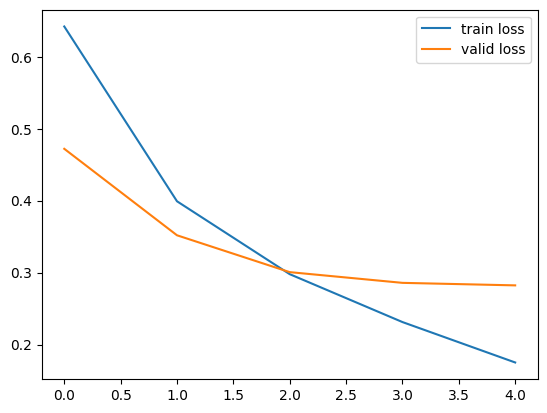

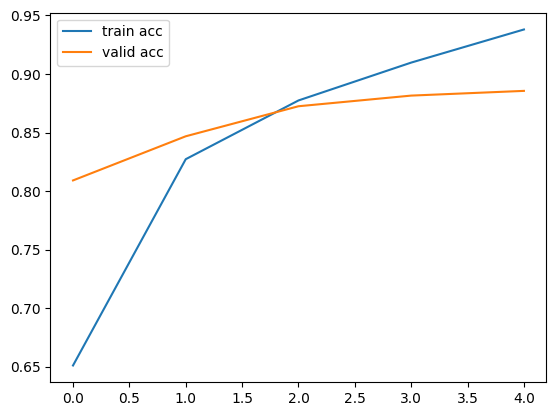

In [ ]:
batch_size = 512
train_loader = data_loader(train_dataset, batch_size, pad_sequence,shuffle=True)
valid_loader = data_loader(valid_dataset, batch_size, pad_sequence)
test_loader = data_loader(test_dataset, batch_size,  pad_sequence)

print(f"length of vocab: {len(vocab)}")


# build CNN
class myCNN(torch.nn.Module):
  def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx):
    super().__init__()
    self.embedding = torch.nn.Embedding(vocab_size, embedding_dim,padding_idx=pad_idx)
    self.conv0 = torch.nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[0], embedding_dim))
    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[1], embedding_dim))
    self.fc = torch.nn.Linear(len(filter_sizes) * n_filters, output_dim)
    self.dropout = torch.nn.Dropout(dropout)

  def forward(self, ids):
    # [batch_size, seq_len] at beginning
    embedded = self.dropout(self.embedding(ids))
    print(f"first embedded shape {embedded.shape}")
    # [batch_size,seq_len, embed_dimsion]
    embedded = embedded.unsqueeze(1) # In PyTorch, unsqueeze(dim) adds a new dimension of size one at the specified dim. For unsqueeze(1), 256*300 becomes 1*256*300
    print(f"embedded shape {embedded.shape}")
    # [batch_size, 1, seq_len, dimension]
    conved0 = torch.relu(self.conv0(embedded).squeeze(3)) # torch.relu(self.conv0(embedded) will return [batch-size, n_filters, seq-filter_size+1, 1]
    print(f"conved0 shape {conved0.shape}") ## note there will also bias randomly initialized!!!!
    # [batch_size, n_filters, seq_len - filter_size+1]
    conved1 = torch.relu(self.conv1(embedded).squeeze(3))
    print(f"conved1 shape {conved1.shape}")
    pooled0 = torch.nn.functional.max_pool1d(conved0, conved0.shape[2]).squeeze(2)
    print(f"pooled0 shape {pooled0.shape}")
    # [batch_size,n_filters]
    pooled1 = torch.nn.functional.max_pool1d(conved1, conved1.shape[2]).squeeze(2)
    print(f"pooled1 shape {pooled1.shape}")
    cat = self.dropout(torch.cat((pooled0, pooled1), dim=1))
    print(f"cat shape {cat.shape}")
    prediction = self.fc(cat)
    print(f"prediction shape {prediction.shape}")
    return prediction

vocab_size = len(vocab)
embed_dim = 300
n_filters = 100
filter_sizes = [8,16] # this actually means a filter with 8*embed_dimension, 16*embed_dimension
# this is saying that we are looking at 8-gram, 16-gram, so these values usually  are 2,3,4
# note we can also use something like [(8,8),(16,16)]
output_dim = len(train_dataset.unique("label"))
dropout = 0.25
pad_idx = vocab["<pad>"]

model = myCNN(vocab_size, embed_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx)

vectors = torchtext.vocab.GloVe(name='6B',dim=300)
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
model.embedding.weight.data = pretrained_embedding

import torch.nn as nn
import torch.optim as optim


def accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy
#

optim = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion.to(device)
model.to(device)

# define train function with batch
def train(model, data_loader, optimizer, criterion):
  epoch_loss = 0
  epoch_acc = 0
  model.train()
  for batch in tqdm.tqdm(data_loader, desc="training..."):
    ids = batch['ids'].to(device)
    labels = batch['labels'].to(device)
    optimizer.zero_grad()
    predictions = model(ids).squeeze(1)
    loss = criterion(predictions, labels)
    acc = accuracy(predictions, labels)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

def evaluate(model, data_loader, criterion):
  epoch_loss = 0
  epoch_acc = 0
  model.eval()
  with torch.no_grad():
    for batch in data_loader:
      ids = batch['ids'].to(device)
      labels = batch['labels'].to(device)
      predictions = model(ids).squeeze(1)
      loss = criterion(predictions, labels)
      acc = accuracy(predictions, labels)
      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss / len(data_loader), epoch_acc / len(data_loader)


epochs= 5
# loop through epoch and record train and valid loss and accurcay
from collections import defaultdict
import tqdm

train_loss = defaultdict(list)
train_acc = defaultdict(list)
valid_loss = defaultdict(list)
valid_acc = defaultdict(list)
best_valid_loss = float('inf')
for epoch in tqdm.tqdm(range(epochs)):
  train_loss_epoch, train_acc_epoch = train(model, train_loader, optim, criterion)
  valid_loss_epoch, valid_acc_epoch = evaluate(model, valid_loader, criterion)
  train_loss[epoch].append(train_loss_epoch)
  train_acc[epoch].append(train_acc_epoch)
  valid_loss[epoch].append(valid_loss_epoch)
  valid_acc[epoch].append(valid_acc_epoch)
  if valid_loss_epoch < best_valid_loss:
        best_valid_loss = valid_loss_epoch
        torch.save(model.state_dict(), "cnn.pt")
  print(f"epoch: {epoch}")
  print(f"train_loss: {train_loss_epoch:.3f}, train_acc: {train_acc_epoch:.3f}")
  print(f"valid_loss: {valid_loss_epoch:.3f}, valid_acc: {valid_acc_epoch:.3f}")

# plot train and valid loss
import matplotlib.pyplot as plt
plt.plot(train_loss.values(), label='train loss')
plt.plot(valid_loss.values(), label='valid loss')
plt.legend()
plt.show()

# plot train and valid accuracy
plt.plot(train_acc.values(), label='train acc')
plt.plot(valid_acc.values(), label='valid acc')
plt.legend()
plt.show()





In [ ]:
# batch_size = 128
# train_loader = data_loader(train_dataset, batch_size, pad_sequence,shuffle=True)
# valid_loader = data_loader(valid_dataset, batch_size, pad_sequence)
# test_loader = data_loader(test_dataset, batch_size,  pad_sequence)

# print(f"length of vocab: {len(vocab)}")


# # build CNN using a predefined kernel size, not necessily use all the embed dimension, very computationally expensive!!!!
# # also because need to eventually reduce dimension, it is not learning any better neither
# class myCNN(torch.nn.Module):
#   def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx):
#     super().__init__()
#     self.embedding = torch.nn.Embedding(vocab_size, embedding_dim,padding_idx=pad_idx)
#     self.conv0 = torch.nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=filter_sizes[0])
#     self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=filter_sizes[1])
#     self.fc = torch.nn.Linear(len(filter_sizes) * n_filters, output_dim)
#     self.dropout = torch.nn.Dropout(dropout)

#   def forward(self, ids):
#     # [batch_size, seq_len] at beginning
#     embedded = self.dropout(self.embedding(ids))
#     print(f"first embedded shape {embedded.shape}")
#     # [batch_size,seq_len, embed_dimsion]
#     embedded = embedded.unsqueeze(1) # In PyTorch, unsqueeze(dim) adds a new dimension of size one at the specified dim. For unsqueeze(1), 256*300 becomes 1*256*300
#     print(f"embedded shape {embedded.shape}")
#     # [batch_size, 1, seq_len, dimension]
#     conved0 = torch.relu(self.conv0(embedded).squeeze(3)) # in
#     print(f"conved0 shape {conved0.shape}")
#     # [batch_size, n_filters, seq_len - filter_size+1]
#     conved1 = torch.relu(self.conv1(embedded).squeeze(3))
#     print(f"conved1 shape {conved1.shape}")
#     output, _ = torch.max(conved0, dim=-1, keepdim=True) # max pooling by get the max of last dim
#     pooled0 = output.squeeze(3)
#     print(f"middle pooled0 shape {pooled0.shape}")
#     output, _ = torch.max(pooled0, dim=-1, keepdim=True) # max pooling by get the max of last dim
#     pooled0 = output.squeeze(2)
#     print(f"pooled0 shape {pooled0.shape}")
#     # [batch_size,n_filters]
#     output, _ = torch.max(conved1, dim=-1, keepdim=True)
#     pooled1 = output.squeeze(3)
#     print(f"middle pooled1 shape {pooled0.shape}")
#     output, _ = torch.max(pooled1, dim=-1, keepdim=True) # max pooling by get the max of last dim
#     pooled1 = output.squeeze(2)
#     print(f"pooled1 shape {pooled1.shape}")
#     cat = self.dropout(torch.cat((pooled0, pooled1), dim=1))
#     print(f"cat shape {cat.shape}")
#     prediction = self.fc(cat)
#     print(f"prediction shape {prediction.shape}")
#     return prediction

# vocab_size = len(vocab)
# embed_dim = 300
# n_filters = 100
# filter_sizes = [(8,200),(16,200)] # this actually means a filter with 8*embed_dimension, 16*embed_dimension
# # this is saying that we are looking at 8-gram, 16-gram, so these values usually  are 2,3,4
# # note we can also use something like [(8,8),(16,16)]
# output_dim = len(train_dataset.unique("label"))
# dropout = 0.25
# pad_idx = vocab["<pad>"]

# model = myCNN(vocab_size, embed_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx)

# vectors = torchtext.vocab.GloVe(name='6B',dim=300)
# pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
# model.embedding.weight.data = pretrained_embedding


# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)


# print(f"The model has {count_parameters(model):,} trainable parameters")

# import torch.nn as nn
# import torch.optim as optim


# def accuracy(prediction, label):
#     batch_size, _ = prediction.shape
#     predicted_classes = prediction.argmax(dim=-1)
#     correct_predictions = predicted_classes.eq(label).sum()
#     accuracy = correct_predictions / batch_size
#     return accuracy
# #

# optim = optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# criterion.to(device)
# model.to(device)

# # define train function with batch
# def train(model, data_loader, optimizer, criterion):
#   epoch_loss = 0
#   epoch_acc = 0
#   model.train()
#   for batch in tqdm.tqdm(data_loader, desc="training..."):
#     ids = batch['ids'].to(device)
#     labels = batch['labels'].to(device)
#     optimizer.zero_grad()
#     predictions = model(ids).squeeze(1)
#     loss = criterion(predictions, labels)
#     acc = accuracy(predictions, labels)
#     loss.backward()
#     optimizer.step()
#     epoch_loss += loss.item()
#     epoch_acc += acc.item()
#   return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

# def evaluate(model, data_loader, criterion):
#   epoch_loss = 0
#   epoch_acc = 0
#   model.eval()
#   with torch.no_grad():
#     for batch in data_loader:
#       ids = batch['ids'].to(device)
#       labels = batch['labels'].to(device)
#       predictions = model(ids).squeeze(1)
#       loss = criterion(predictions, labels)
#       acc = accuracy(predictions, labels)
#       epoch_loss += loss.item()
#       epoch_acc += acc.item()

#   return epoch_loss / len(data_loader), epoch_acc / len(data_loader)


# epochs= 1
# # loop through epoch and record train and valid loss and accurcay
# from collections import defaultdict
# import tqdm

# train_loss = defaultdict(list)
# train_acc = defaultdict(list)
# valid_loss = defaultdict(list)
# valid_acc = defaultdict(list)
# for epoch in tqdm.tqdm(range(epochs)):
#   train_loss_epoch, train_acc_epoch = train(model, train_loader, optim, criterion)
#   valid_loss_epoch, valid_acc_epoch = evaluate(model, valid_loader, criterion)
#   train_loss[epoch].append(train_loss_epoch)
#   train_acc[epoch].append(train_acc_epoch)
#   valid_loss[epoch].append(valid_loss_epoch)
#   valid_acc[epoch].append(valid_acc_epoch)
#   print(f"epoch: {epoch}")
#   print(f"train_loss: {train_loss_epoch:.3f}, train_acc: {train_acc_epoch:.3f}")
#   print(f"valid_loss: {valid_loss_epoch:.3f}, valid_acc: {valid_acc_epoch:.3f}")

# # plot train and valid loss
# import matplotlib.pyplot as plt
# plt.plot(train_loss.values(), label='train loss')
# plt.plot(valid_loss.values(), label='valid loss')
# plt.legend()
# plt.show()

# # plot train and valid accuracy
# plt.plot(train_acc.values(), label='train acc')
# plt.plot(valid_acc.values(), label='valid acc')
# plt.legend()
# plt.show()



